In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [2]:
df_age = pd.read_csv('train_age.csv')
df_gen = pd.read_csv('train_gender.csv')

In [3]:
df_age.head()

,imageId,age
0,0,89.0
1,1,72.0
2,2,25.0
3,3,68.0
4,4,37.0


In [4]:
df_gen.head()

,imageId,gender
0,0,0
1,1,0
2,2,1
3,3,1
4,4,0


In [5]:
im = []
for i in tqdm(sorted(os.listdir('kaggle/kaggle/train/'))):
    img = cv2.imread('kaggle/kaggle/train/'+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = 255-img
    img = cv2.resize(img,(128,128))
    im.append(img)

age = df_age['age']
gen = df_gen['gender']
data = {'Image' : im, 'Age' : age, 'Gender' : gen}

100%|████████████████████████████████████████████████████████████████████████████| 10702/10702 [04:49<00:00, 36.98it/s]


In [6]:
df = pd.DataFrame(data)

In [7]:
df

,Image,Age,Gender
0,"[[189, 236, 251, 250, 249, 247, 249, 247, 248,...",89.0,0
1,"[[236, 254, 254, 254, 254, 254, 254, 254, 254,...",72.0,0
2,"[[201, 253, 255, 255, 255, 255, 255, 255, 255,...",25.0,1
3,"[[255, 255, 255, 251, 215, 226, 230, 232, 232,...",68.0,1
4,"[[248, 248, 248, 248, 248, 248, 248, 248, 248,...",37.0,0
...,...,...,...
10697,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",79.0,0
10698,"[[232, 232, 232, 232, 232, 232, 232, 232, 232,...",67.0,0
10699,"[[246, 246, 246, 246, 246, 246, 246, 246, 246,...",66.0,1
10700,"[[253, 253, 253, 253, 253, 253, 253, 253, 253,...",78.0,0


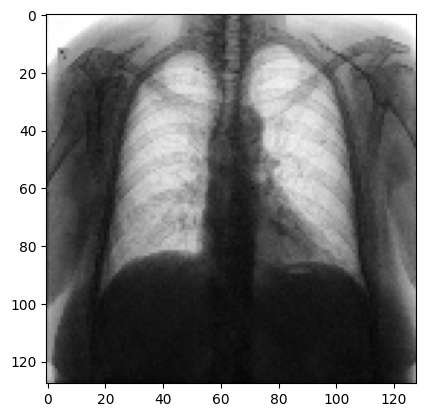

In [8]:
plt.imshow(cv2.cvtColor(df['Image'].iloc[1], cv2.COLOR_BGR2RGB))

In [9]:
x = np.array(data['Image'])
y = np.array(data['Gender'])

x = x.reshape((x.shape[0],x.shape[1],x.shape[2],1))
y = y.reshape(-1,1)
x = x/255
print(x.shape, y.shape)

(10702, 128, 128, 1) (10702, 1)


DCNN model

In [10]:
import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Activation, BatchNormalization 

In [11]:
def blockc(y,filt,kern):
    x = tensorflow.keras.layers.Conv2D(filt, kern, padding='same')(y)
    x = tensorflow.keras.layers.MaxPool2D(2, strides = 2, padding='same')(x)
    x = tensorflow.keras.layers.BatchNormalization()(x)
    x = tensorflow.keras.layers.Activation('relu')(x)
    return x

In [12]:
tensorflow.keras.backend.clear_session()
model_gender = tensorflow.keras.Sequential()

In [13]:
inp = tensorflow.keras.layers.Input((128,128,1))
c0 = tensorflow.keras.layers.Conv2D(4,3,padding='same')(inp)
c1 = blockc(c0,16,3)
c2 = blockc(c1,32,3)
c3 = blockc(c2,64,3)
c4 = blockc(c3,128,3)
c5 = blockc(c4,64,3)
c6 = blockc(c5,32,3)
c6 = tensorflow.keras.layers.GlobalAveragePooling2D()(c6)
out = tensorflow.keras.layers.Dense(1,activation='sigmoid')(c6)
model_gender = tensorflow.keras.Model(inputs=[inp], outputs=[out])

In [14]:
model_gender.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_gender.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 4)         │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 16)        │             592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 191,257 (747.10 KB)

 Trainable params: 190,585 (744.47 KB)

 Non-trainable params: 672 (2.62 KB)

In [15]:
history = model_gender.fit(x,y,steps_per_epoch=(10000//10), validation_split=0.2, epochs=5)

Epoch 1/5
 951/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7870 - loss: 0.4625

C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 73s 62ms/step - accuracy: 0.7900 - loss: 0.4576 - val_accuracy: 0.9197 - val_loss: 0.1960
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.9262 - loss: 0.2039 - val_accuracy: 0.9528 - val_loss: 0.1284
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 64s 64ms/step - accuracy: 0.9528 - loss: 0.1415 - val_accuracy: 0.9617 - val_loss: 0.1190
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 65s 65ms/step - accuracy: 0.9635 - loss: 0.1142 - val_accuracy: 0.9360 - val_loss: 0.1933
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.9657 - loss: 0.1014 - val_accuracy: 0.9622 - val_loss: 0.1018


<Axes: >

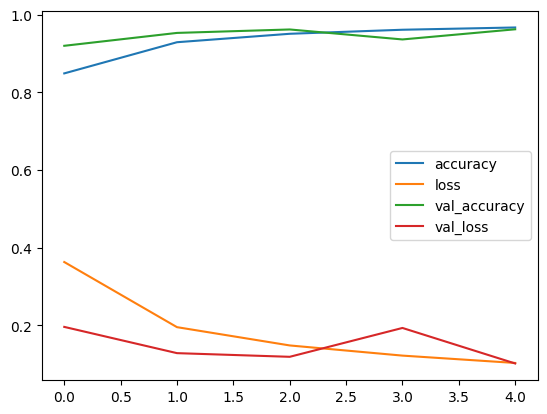

In [16]:
pd.DataFrame(history.history).plot()

In [17]:
model_gender.save('model_gender.h5')

AGE PREDICTION

In [19]:
y = np.array(data['Age'])
y = y.reshape(-1,1)
y.shape

(10702, 1)

In [21]:
tensorflow.keras.backend.clear_session()
model_age = tensorflow.keras.Sequential()

inp = tensorflow.keras.layers.Input((128,128,1))
c0 = tensorflow.keras.layers.Conv2D(4,3,padding='same')(inp)
c0 = tensorflow.keras.layers.MaxPool2D(2)(c0)
c1 = blockc(c0,16,3)
c2 = blockc(c1,32,3)
c3 = blockc(c2,64,3)
c4 = blockc(c3,128,3)
c5 = blockc(c4,64,3)
c6 = blockc(c5,32,3)
c6 = tensorflow.keras.layers.GlobalAveragePooling2D()(c6)
c7 = tensorflow.keras.layers.Flatten()(c6)
c8 = tensorflow.keras.layers.Dense(100, activation='linear')(c7)
c9 = tensorflow.keras.layers.Dense(50, activation='linear')(c8)
out = tensorflow.keras.layers.Dense(1, activation='linear')(c9)
model_age = tensorflow.keras.Model(inputs = [inp], outputs = [out])

In [22]:
model_age.compile(loss = 'mean_squared_error', optimizer='adam', metrics = ['mse'])
model_age.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 4)         │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │             592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 199,625 (779.79 KB)

 Trainable params: 198,953 (777.16 KB)

 Non-trainable params: 672 (2.62 KB)

In [23]:
history = model_age.fit(x,y, steps_per_epoch=(10000//10), validation_split=0.2, epochs= 10)

Epoch 1/10
 950/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 628.7056 - mse: 628.7054

C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 613.3833 - mse: 613.3930 - val_loss: 132.3637 - val_mse: 132.2363
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 166.3577 - mse: 166.3689 - val_loss: 111.1490 - val_mse: 111.1439
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 140.6472 - mse: 140.6579 - val_loss: 101.8147 - val_mse: 101.6879
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - loss: 123.5404 - mse: 123.5392 - val_loss: 124.6030 - val_mse: 124.5497
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 114.5872 - mse: 114.5816 - val_loss: 163.0783 - val_mse: 162.6666
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - loss: 100.9622 - mse: 100.9714 - val_loss: 103.2986 - val_mse: 103.3617
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 99.6890 - mse: 99.6794 - val_loss: 86.1036 - val_mse: 86.1191
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - loss: 89.8512 - mse: 89.8201 - val_loss: 145.44

<Axes: >

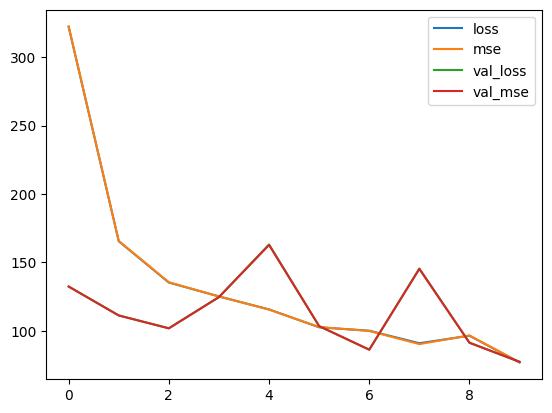

In [24]:
pd.DataFrame(history.history).plot()

In [25]:
model_age.save('model_age.h5')

Testing the models

In [33]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

y_pred = model_gender.predict(x)
pred = []
for i in tqdm(y_pred):
    if i<0.5:
        pred.append(0)
    else:
        pred.append(1)
pred = np.array(pred)

print(pred.shape,y.shape)
print(pred[5:15],gen[5:15])

335/335 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step


100%|████████████████████████████████████████████████████████████████████████| 10702/10702 [00:00<00:00, 342503.20it/s]

(10702,) (10702, 1)
[0 1 1 0 1 1 1 1 0 1] 5     1
6     1
7     1
8     0
9     1
10    1
11    1
12    1
13    0
14    1
Name: gender, dtype: int64


In [28]:
pred = np.round(model_age.predict(x))
print(pred[5:15],age[5:15])

335/335 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
[[57.]
 [40.]
 [44.]
 [73.]
 [38.]
 [72.]
 [67.]
 [57.]
 [71.]
 [27.]] 5     62.0
6     52.0
7     46.0
8     83.0
9     33.0
10    82.0
11    78.0
12    61.0
13    74.0
14    28.0
Name: age, dtype: float64


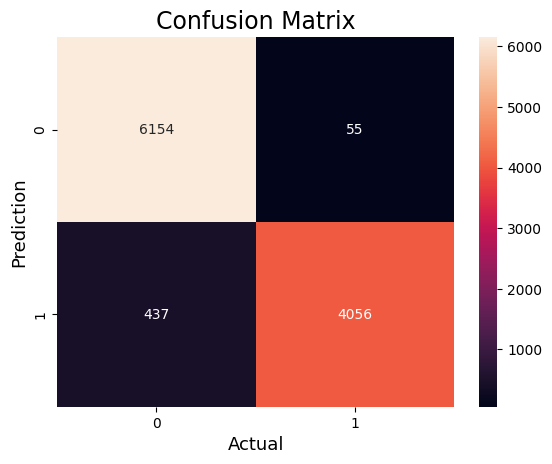

Accuracy   : 0.9540272846196972
Precision : 0.9866212600340549
Recall    : 0.9027375918094814
F1-score  : 0.9428172942817294


In [34]:
import seaborn as sns
cm = confusion_matrix(gen,pred)
 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
accuracy = accuracy_score(gen, pred)
print("Accuracy   :", accuracy)
precision = precision_score(gen, pred)
print("Precision :", precision)
recall = recall_score(gen, pred)
print("Recall    :", recall)
F1_score = f1_score(gen, pred)
print("F1-score  :", F1_score)


In [38]:
from sklearn.metrics import r2_score

p = model_age.predict(x)

print(r2_score(age,p))

335/335 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
0.8462106843763988
